A Physics Informed Neural Network

The lid-driven cavity is a classic fluid dynamics problem involving the flow inside a closed cavity (usually square or rectangular) where one of the walls moves tangentially to itself, typically in the horizontal direction. This movement drives the flow within the cavity, creating complex patterns of vortices, eddies, and recirculating flows, depending on factors like the cavity's geometry, the speed of the moving wall, and the fluid's properties (such as viscosity).

**Installing Nvidia Modulus Library**

In [1]:
!pip install nvidia-modulus nvidia-modulus-sym==1.5.0
!pip install torch==2.3.0


  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.3 kB)
Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl (797.1 MB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached triton-3.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (209.4 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      

In [2]:
import torch
print (torch.__version__)

2.3.0+cu121


In [3]:
import os
import warnings
import torch
import matplotlib.pyplot as plt
from sympy import Symbol, Eq, Abs


Navier Stoke PDE

nu = Kinematic Viscocity
rho = Density of the fluid

In [4]:
from modulus.sym.eq.pdes.navier_stokes import NavierStokes

In [5]:
ns = NavierStokes(nu=0.01, rho=1.0, dim=2, time=False)

In [6]:
ns.equations

{'continuity': 1.0*Derivative(u(x, y), x) + 1.0*Derivative(v(x, y), y),
 'momentum_x': 1.0*u(x, y)*Derivative(u(x, y), x) + 1.0*v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.01*Derivative(u(x, y), (x, 2)) - 0.01*Derivative(u(x, y), (y, 2)),
 'momentum_y': 1.0*u(x, y)*Derivative(v(x, y), x) + 1.0*v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.01*Derivative(v(x, y), (x, 2)) - 0.01*Derivative(v(x, y), (y, 2))}

In [7]:
ns.equations['continuity']

1.0*Derivative(u(x, y), x) + 1.0*Derivative(v(x, y), y)

In [8]:
ns.equations['momentum_x']

1.0*u(x, y)*Derivative(u(x, y), x) + 1.0*v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.01*Derivative(u(x, y), (x, 2)) - 0.01*Derivative(u(x, y), (y, 2))

In [9]:
ns.equations['momentum_y']

1.0*u(x, y)*Derivative(v(x, y), x) + 1.0*v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.01*Derivative(v(x, y), (x, 2)) - 0.01*Derivative(v(x, y), (y, 2))

In [10]:
ns.pprint()

continuity: 1.0*Derivative(u(x, y), x) + 1.0*Derivative(v(x, y), y)
momentum_x: 1.0*u(x, y)*Derivative(u(x, y), x) + 1.0*v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.01*Derivative(u(x, y), (x, 2)) - 0.01*Derivative(u(x, y), (y, 2))
momentum_y: 1.0*u(x, y)*Derivative(v(x, y), x) + 1.0*v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.01*Derivative(v(x, y), (x, 2)) - 0.01*Derivative(v(x, y), (y, 2))


**Neural Network**

In [11]:
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.models.activation import Activation
from modulus.sym.key import Key

flow_net = FullyConnectedArch(

  # Science and Engineering Network
  # u =  : The Horizontal component of the velocity
  # v =  : The Vertical component of the velocity
  # x =  : The Horizontal component of the position
  # y =  : The Vertical component of the position
  # p =  : The Pressure of the fluid


  input_keys=[Key("x"), Key("y")],
  output_keys=[Key("u"), Key("v"), Key("p") ],

  #Neural Networks
  layer_size = 512,
  nr_layers = 6,
  activation_fn = Activation.SILU,
  adaptive_activations = False,
  weight_norm = True

)


In [12]:
flow_net

FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)

In [13]:
nodes = ns.make_nodes() + [flow_net.make_node(name="flow_network")]

In [14]:
nodes

Visualize the Geometry

In [15]:
from modulus.sym.geometry.primitives_2d import Rectangle
height = 0.1
width = 0.1
x,y = Symbol('x'), Symbol('y')
rec = Rectangle((-width/2, -height/2),(width/2, height/2))


In [16]:
rec

#Science and Engineering: Constraints

---



In [17]:
from modulus.sym.domain import Domain
ldc_domain = Domain()


Boundary Constraints

In [18]:
from modulus.sym.domain.constraint import(
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint
)

In [19]:
#top wall
top_wall = PointwiseBoundaryConstraint(
    nodes = nodes,
    geometry = rec,
    outvar={
        "u": 1.0,
        "v": 0,
    },
    #batch_size = cfg.batch_size.TopWall
    batch_size = 1000,
    lambda_weighting = {"u": 1.0 - 20 * Abs(x), "v":1.0}, #weight edges to be zero
    criteria=(Eq(y, height/2)) # y = 0.05
)

#no slip
no_slip = PointwiseBoundaryConstraint(
    nodes = nodes,
    geometry=rec,
    outvar={
        "u": 0,
        "v": 0,
    },
    #batch_size = cfg.batch_size.NoSlip
    batch_size = 1000,
    criteria = y < height / 2
)



In [20]:
# Science and Engineering
ldc_domain.add_constraint(top_wall, "top_wall")
ldc_domain.add_constraint(no_slip, "no_slip")

Interior Constraints

In [21]:
interior = PointwiseInteriorConstraint(
    nodes = nodes,
    geometry = rec,
    batch_size = 4000,
    outvar={
        "continuity": 0,
        "momentum_x": 0,
        "momentum_y": 0,
    },
    lambda_weighting = {
        "continuity": Symbol("sdf"),
        "momentum_x": Symbol("sdf"),
        "momentum_y": Symbol("sdf")
    }
)

ldc_domain.add_constraint(interior,"interior")

Solver Configuration

In [22]:
%%writefile config.yaml

defaults:
  - modulus_default
  - arch: fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

scheduler:
  decay_rate: 0.95
  decay_steps: 4000

training:
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  max_steps: 10000

batch_size:
  TopWall: 1000
  NoSlip: 1000
  Interior: 4000

graph:
  func_arch: true


Writing config.yaml


In [23]:
import modulus.sym
from modulus.sym.hydra import to_yaml
from modulus.sym.hydra.utils import compose
from modulus.sym.hydra.config import ModulusConfig

cfg = compose(config_path=".", config_name="config.yaml")
cfg.network_dir = 'outputs' # Set the network directory for checkpoints
print(to_yaml(cfg))

/usr/local/lib/python3.10/dist-packages/modulus/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(


training:
  max_steps: 10000
  grad_agg_freq: 1
  rec_results_freq: 1000
  rec_validation_freq: 1000
  rec_inference_freq: 2000
  rec_monitor_freq: 1000
  rec_constraint_freq: 2000
  save_network_freq: 1000
  print_stats_freq: 100
  summary_freq: 1000
  amp: false
  amp_dtype: float16
  ntk:
    use_ntk: false
    save_name: null
    run_freq: 1000
graph:
  func_arch: true
  func_arch_allow_partial_hessian: true
stop_criterion:
  metric: null
  min_delta: null
  patience: 50000
  mode: min
  freq: 1000
  strict: false
profiler:
  profile: false
  start_step: 0
  end_step: 100
  name: nvtx
network_dir: outputs
initialization_network_dir: ''
save_filetypes: vtk
summary_histograms: false
jit: true
jit_use_nvfuser: true
jit_arch_mode: only_activation
jit_autograd_nodes: false
cuda_graphs: true
cuda_graph_warmup: 20
find_unused_parameters: false
broadcast_buffers: false
device: ''
debug: false
run_mode: train
arch:
  fully_connected:
    arch_type: fully_connected
    input_keys: ???
    ou

#Create Solver

In [24]:
from modulus.sym.solver import Solver
slv = Solver(cfg, ldc_domain)

Configure the Solver

In [26]:
import logging

def configure_logging():
  logger = logging.getLogger()
  logger.setLevel(logging.DEBUG)

  # Remove all existing handlers
  while logger.handlers:
    logger.handlers.pop()

  # Create a stream handler
  stream_handler = logging.StreamHandler()
  stream_handler.setLevel(logging.DEBUG)

  # Create a formatter and set it for the handler
  formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
  stream_handler.setFormatter(formatter)

  # Add the handler to the logger
  logger.addHandler(stream_handler)

configure_logging()
import logging

def configure_logging():
  logger = logging.getLogger()
  logger.setLevel(logging.DEBUG)

  # Remove all existing handlers
  while logger.handlers:
    logger.handlers.pop()

  # Create a stream handler
  stream_handler = logging.StreamHandler()
  stream_handler.setLevel(logging.DEBUG)

  # Create a formatter and set it for the handler
  formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
  stream_handler.setFormatter(formatter)

  # Add the handler to the logger
  logger.addHandler(stream_handler)

configure_logging()

logging.debug("logging is configured correctly")
logging.debug("logging is configured correctly")

2024-11-08 12:31:56,859 - root - DEBUG - logging is configured correctly
2024-11-08 12:31:56,860 - root - DEBUG - logging is configured correctly


In [29]:
import torch
print (torch.__version__)

2.3.0+cu121


In [28]:
slv.solve()

2024-11-08 12:32:06,925 - modulus.sym.trainer - WARNING - Installed PyTorch version 2.3.0+cu121 is not TorchScript supported in Modulus. Version 2.1.0a0+4136153 is officially supported.
2024-11-08 12:32:06,934 - modulus.sym.trainer - INFO - attempting to restore from: /content/outputs
2024-11-08 12:32:06,935 - modulus.sym.trainer - WARNING - optimizer checkpoint not found
2024-11-08 12:32:06,936 - modulus.sym.trainer - WARNING - model flow_network.0.pth not found
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
2024-11-08 12:32:08,949 - modulus.sym.trainer - DEBUG - [step:          0] saved constraint results to outputs
2024-11-08 12:32:08,950 - modulus.sym.trainer - INFO - 

In [33]:
torch.load('./outputs/optim_checkpoint.0.pth').keys()

dict_keys(['step', 'optimizer_state_dict', 'aggregator_state_dict', 'scheduler_state_dict', 'scaler_state_dict'])

In [36]:
torch.load('./outputs/flow_network.0.pth').keys()

odict_keys(['_impl.layers.0.linear.weight', '_impl.layers.0.linear.weight_g', '_impl.layers.0.linear.bias', '_impl.layers.1.linear.weight', '_impl.layers.1.linear.weight_g', '_impl.layers.1.linear.bias', '_impl.layers.2.linear.weight', '_impl.layers.2.linear.weight_g', '_impl.layers.2.linear.bias', '_impl.layers.3.linear.weight', '_impl.layers.3.linear.weight_g', '_impl.layers.3.linear.bias', '_impl.layers.4.linear.weight', '_impl.layers.4.linear.weight_g', '_impl.layers.4.linear.bias', '_impl.layers.5.linear.weight', '_impl.layers.5.linear.weight_g', '_impl.layers.5.linear.bias', '_impl.final_layer.linear.weight', '_impl.final_layer.linear.bias'])

In [39]:
checkpoint = torch.load('./outputs/flow_network.0.pth')
try:
  checkpoint.eval()
except AttributeError as error:
  print(error)

flow_net.load_state_dict(checkpoint)
flow_net

'collections.OrderedDict' object has no attribute 'eval'


FullyConnectedArch(
  (_impl): FullyConnectedArchCore(
    (layers): ModuleList(
      (0): FCLayer(
        (linear): WeightNormLinear(in_features=2, out_features=512, bias=True)
      )
      (1-5): 5 x FCLayer(
        (linear): WeightNormLinear(in_features=512, out_features=512, bias=True)
      )
    )
    (final_layer): FCLayer(
      (activation_fn): Identity()
      (linear): Linear(in_features=512, out_features=3, bias=True)
    )
  )
)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flow_net({"x": torch.tensor([0]).to(device), "y": torch.tensor([0.05]).to(device)})


{'u': tensor([0.9844], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'v': tensor([0.0026], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'p': tensor([-0.0437], device='cuda:0', grad_fn=<SplitWithSizesBackward0>)}

In [41]:
# Illustration
arch = FullyConnectedArch(
    [Key("x", size=2)],
    [Key("y", size=2)],
    layer_size=64,
    nr_layers=2
)

model = arch.make_node(name="test_model")
input = {"x": torch.randn(10,2)}
output = model.evaluate(input)
output

{'y': tensor([[-0.0051,  0.0110],
         [ 0.0139,  0.1162],
         [ 0.0248, -0.2190],
         [-0.0687, -0.4049],
         [-0.0294, -0.2857],
         [-0.6304,  0.2740],
         [ 0.0157, -0.0314],
         [ 0.0805, -0.1285],
         [ 0.1079, -0.0166],
         [ 0.1157,  0.1424]], grad_fn=<SplitWithSizesBackward0>)}

In [42]:
arch(input)

{'y': tensor([[-0.0051,  0.0110],
         [ 0.0139,  0.1162],
         [ 0.0248, -0.2190],
         [-0.0687, -0.4049],
         [-0.0294, -0.2857],
         [-0.6304,  0.2740],
         [ 0.0157, -0.0314],
         [ 0.0805, -0.1285],
         [ 0.1079, -0.0166],
         [ 0.1157,  0.1424]], grad_fn=<SplitWithSizesBackward0>)}

In [43]:
torch.randn(10,2)

tensor([[ 0.8070,  0.3353],
        [ 1.5134, -1.0029],
        [-0.2760,  1.2561],
        [ 0.3693, -0.4444],
        [-0.4659, -0.1356],
        [ 0.1474, -1.0979],
        [-0.6142,  1.4199],
        [-1.8470,  1.3943],
        [ 0.0117, -0.5412],
        [ 1.3688, -1.1758]])

Evaluate the Pytorch Flow Model

In [44]:
torch.randn(5,1)

tensor([[ 2.1633],
        [-0.1352],
        [ 0.5654],
        [-1.1222],
        [-0.3464]])

In [45]:
torch.tensor([0.04])

tensor([0.0400])

In [47]:
torch.rand(5,1)

tensor([[0.8717],
        [0.4584],
        [0.7652],
        [0.7706],
        [0.1023]])

In [48]:
# Top wall point (x,y) = [0,0.05]
flow_net({"x": torch.tensor([0]).to(device), "y": torch.tensor([0.05]).to(device)})

{'u': tensor([0.9844], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'v': tensor([0.0026], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'p': tensor([-0.0437], device='cuda:0', grad_fn=<SplitWithSizesBackward0>)}

In [49]:
(torch.rand(5,1) * 0.1) - 0.05

tensor([[ 0.0446],
        [ 0.0185],
        [ 0.0450],
        [ 0.0281],
        [-0.0118]])

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move flow_net to the device
flow_net = flow_net.to(device)

# Prepare input tensors and move them to the device
input_data = {
    "x": (torch.rand(5, 1) * 0.1 - 0.05).to(device),
    "y": (torch.rand(5, 1) * 0.1 - 0.05).to(device)
}

# Pass the input data to the model
flow_net(input_data)

{'u': tensor([[-0.1813],
         [-0.0551],
         [-0.0483],
         [-0.0025],
         [-0.0059]], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'v': tensor([[-0.1182],
         [ 0.0024],
         [ 0.1867],
         [ 0.0045],
         [ 0.0034]], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'p': tensor([[ 0.0778],
         [ 0.0278],
         [-0.1719],
         [ 0.0499],
         [ 0.0570]], device='cuda:0', grad_fn=<SplitWithSizesBackward0>)}

In [57]:
flow_net({"x": torch.tensor([0.05]).to(device), "y": torch.tensor([0]).to(device)})

{'u': tensor([-0.0017], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'v': tensor([-0.0013], device='cuda:0', grad_fn=<SplitWithSizesBackward0>),
 'p': tensor([0.0684], device='cuda:0', grad_fn=<SplitWithSizesBackward0>)}

Visualize the Results

In [59]:
#Domain definition
import numpy as np
x_values = np.linspace(-0.05,0.05,100)
y_values = np.linspace(-0.05,0.05,100)
x_grid, y_grid = np.meshgrid(x_values,y_values)

#Flatten the grid arrays to create input for the model
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Conveer to Pytorch tensors
x_tensor = torch.tensor(x_flat, dtype=torch.float32).unsqueeze(1).to(device)
y_tensor = torch.tensor(y_flat, dtype=torch.float32).unsqueeze(1).to(device)

inputs = {"x":x_tensor, "y":y_tensor}



In [62]:
outputs = flow_net(inputs)

# Move tensors to CPU before calling numpy()
u_flat = outputs["u"].to(device).detach().cpu().numpy()
v_flat = outputs["v"].to(device).detach().cpu().numpy()
p_flat = outputs["p"].to(device).detach().cpu().numpy()

# Reshape as needed
u_grid = u_flat.reshape(x_grid.shape)
v_grid = v_flat.reshape(x_grid.shape)
p_grid = p_flat.reshape(x_grid.shape)


2024-11-08 19:44:26,314 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0e9adeec0>
2024-11-08 19:44:26,332 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0f0ff7700>
2024-11-08 19:44:26,349 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0f1048f70>
2024-11-08 19:44:26,388 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-11-08 19:44:26,389 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-11-08 19:44:26,390 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmss10.t

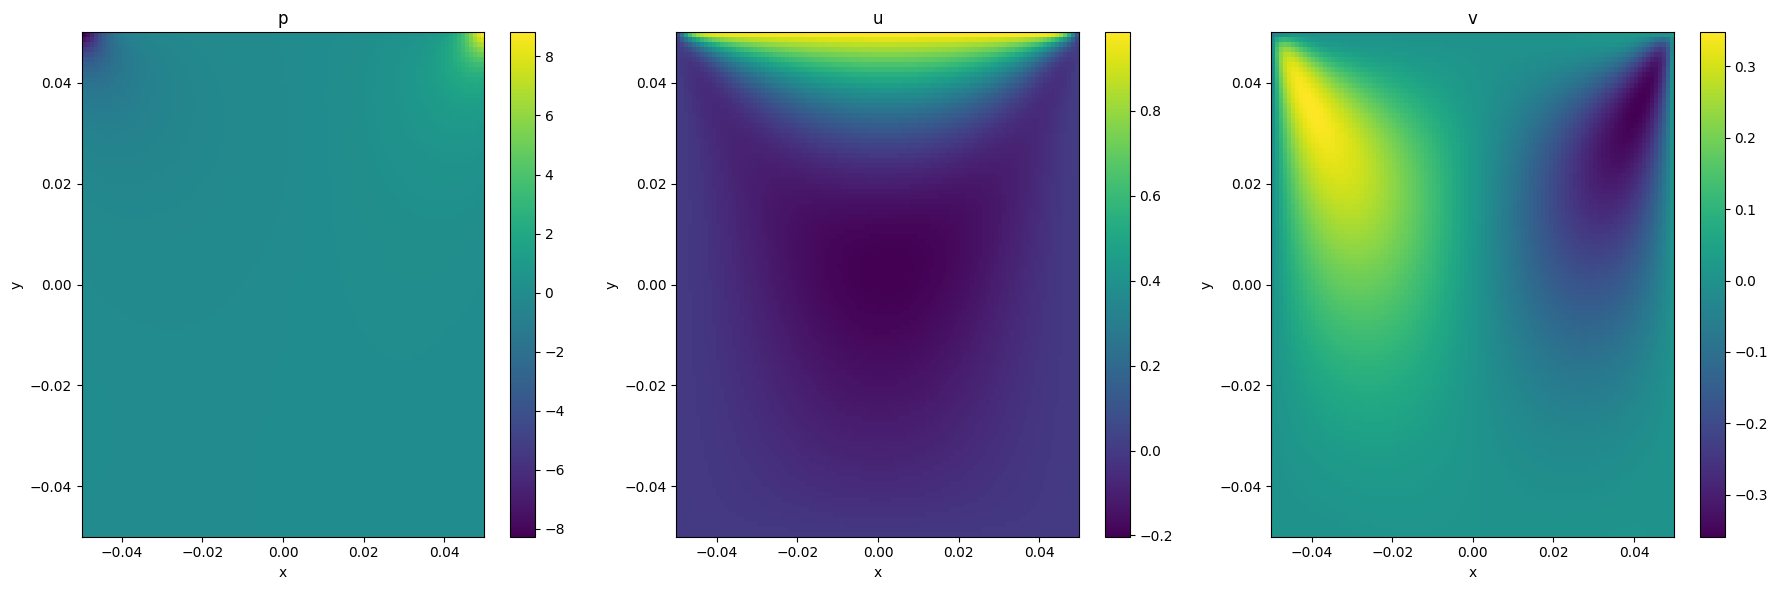

In [64]:
fig, axs = plt.subplots(1,3, figsize=(18,6))

#Plot p
im0 = axs[0].imshow(p_grid, extent=[-0.05,0.05,-0.05,0.05], origin='lower', aspect='auto')
axs[0].set_title('p')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
fig.colorbar(im0, ax=axs[0])

# Plot u
im1 = axs[1].imshow(u_grid, extent=[-0.05,0.05,-0.05,0.05], origin='lower', aspect='auto')
axs[1].set_title('u')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.colorbar(im1, ax=axs[1])

#plot v
im2 = axs[2].imshow(v_grid, extent=[-0.05,0.05,-0.05,0.05], origin='lower', aspect='auto')
axs[2].set_title('v')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


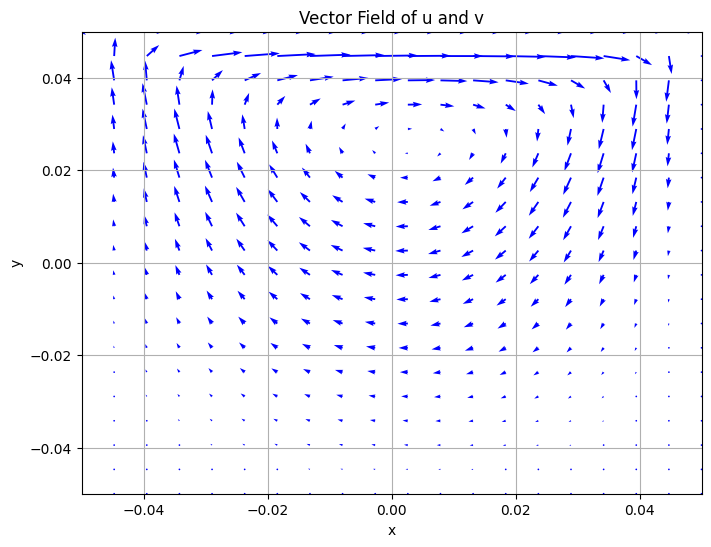

In [65]:
x_values = np.linspace(-0.05,0.05,20)
y_values = np.linspace(-0.05,0.05,20)

x_grid, y_grid = np.meshgrid(x_values,y_values)

x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

x_tensor = torch.tensor(x_flat, dtype=torch.float32).unsqueeze(1).to(device)
y_tensor = torch.tensor(y_flat, dtype=torch.float32).unsqueeze(1).to(device)

inputs = {"x":x_tensor, "y":y_tensor}

outputs = flow_net(inputs)

u_flat = outputs["u"].to(device).detach().cpu().numpy()
v_flat = outputs["v"].to(device).detach().cpu().numpy()
p_flat = outputs["p"].to(device).detach().cpu

u_grid = u_flat.reshape(x_grid.shape)
v_grid = v_flat.reshape(x_grid.shape)

#Plot the vector field
plt.figure(figsize=(8,6))
plt.quiver(x_grid, y_grid, u_grid, v_grid, scale=10, color='blue') #Adjust scale as needed
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vector Field of u and v')
plt.xlim([-0.05,0.05])
plt.ylim([-0.05,0.05])
plt.grid(True)
plt.show()

2024-11-08 20:10:50,768 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7ff0c9ae3610> <matplotlib.colors.Normalize object at 0x7ff0c9ae3610>
2024-11-08 20:10:50,769 - matplotlib.colorbar - DEBUG - colorbar update normal <matplotlib.colors.Normalize object at 0x7ff0c9ae3610> <matplotlib.colors.Normalize object at 0x7ff0c9ae3610>
2024-11-08 20:10:50,773 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0c8020880>
2024-11-08 20:10:50,778 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0c8020880>
2024-11-08 20:10:50,783 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0f46b7280>


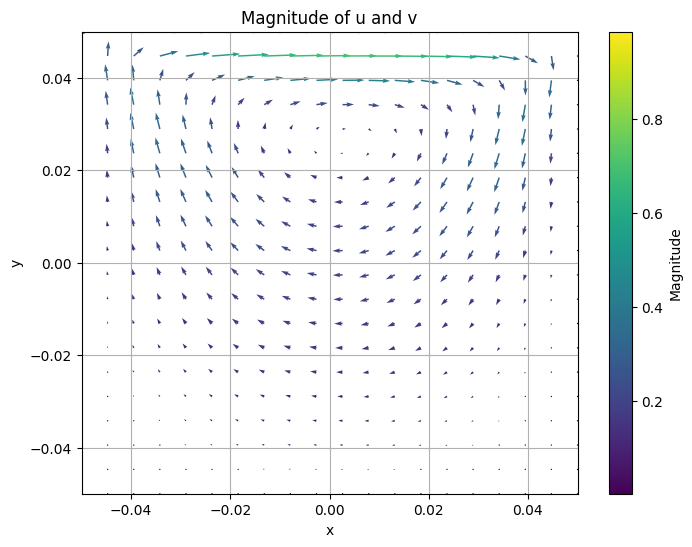

In [67]:
magnitude = np.sqrt(u_grid**2 + v_grid**2)

plt.figure(figsize=(8,6))
plt.quiver(x_grid, y_grid, u_grid, v_grid, magnitude, scale=10, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Magnitude of u and v')
plt.xlim([-0.05,0.05])
plt.ylim([-0.05,0.05])
plt.grid(True)
plt.show()

2024-11-08 20:23:08,485 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7ff0c80722f0>


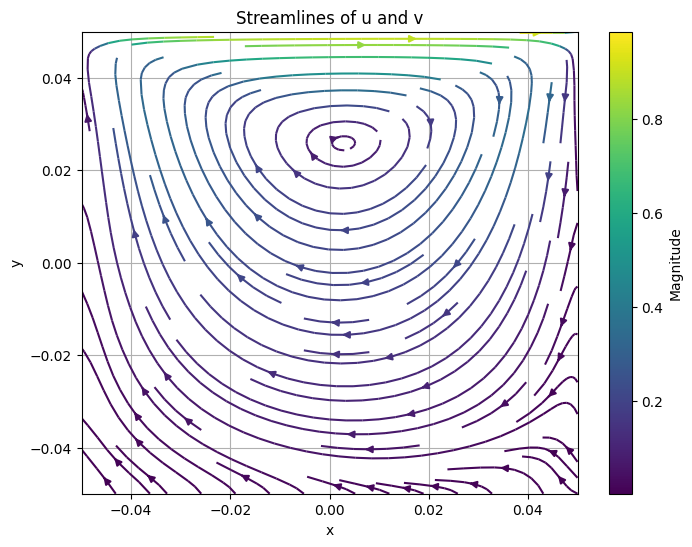

In [68]:
#Plot Streamlines
plt.figure(figsize=(8,6))
plt.streamplot(x_grid, y_grid, u_grid, v_grid, color=magnitude, cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Streamlines of u and v')
plt.xlim([-0.05,0.05])
plt.ylim([-0.05,0.05])
plt.grid(True)
plt.show()